In [2]:
# Import necessary libraries
import sys
import setuptools._distutils as distutils
sys.modules["distutils"] = distutils

from imutils import paths
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns
import pandas as pd
import time

# Define key parameters for reproducibility and clarity
INIT_LR = 1e-4       # Initial learning rate
EPOCHS = 20          # Number of training epochs
BS = 32              # Batch size
IMAGE_DIMS = (224, 224)  # Image dimensions (width, height)

# Directory containing dataset images and allowed classes for this experiment
dataset_dir = "C:/Users/Souma Chakraborty/OneDrive/Desktop/ML_RESEARCH/Fruit And Vegetable Diseases Dataset"
ALLOWED_CLASSES = {"Apple__Healthy", "Apple__Rotten"}


In [3]:
# Define a function to load and preprocess data following research standards:
# - Clear logging of images found/processed.
# - Consistent image resizing and normalization.
# - Label encoding and one-hot conversion.
def load_data():
    data = []
    labels = []
    
    # List all image paths in the dataset directory
    imagePaths = list(paths.list_images(dataset_dir))
    print(f"Found {len(imagePaths)} images in total.")
    
    for imagePath in imagePaths:
        # Extract the class label based on the folder structure
        label = imagePath.split(os.path.sep)[-2]
        if label not in ALLOWED_CLASSES:
            continue

        # Read, resize, and normalize the image
        image = cv2.imread(imagePath)
        if image is None:
            print(f"Failed to load image: {imagePath}")
            continue
        image = cv2.resize(image, IMAGE_DIMS)
        image = img_to_array(image)
        image = image / 255.0
        
        data.append(image)
        labels.append(label)
    
    print(f"\nProcessed {len(data)} images")
    print(f"Unique labels found: {set(labels)}")
    
    if len(data) == 0:
        raise ValueError("No images were processed. Check your dataset directory and paths.")
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    
    # Encode labels and convert to one-hot encoding
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, num_classes=len(le.classes_))
    
    # Split the dataset into training and testing sets using a fixed random state for reproducibility
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)
    
    return trainX, testX, trainY, testY, le

# Execute data loading (run this cell)
trainX, testX, trainY, testY, le = load_data()


Found 31493 images in total.

Processed 2217 images
Unique labels found: {'Apple__Rotten', 'Apple__Healthy'}


In [4]:
# Define the CNN model architecture.
# This architecture is lightweight yet robust, following traditional design practices:
# - Multiple convolutional blocks with batch normalization.
# - MaxPooling layers for downsampling.
# - Fully connected layers at the end.
def build_enhanced_model(input_shape, num_classes):
    model = models.Sequential()
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Additional block for enhanced feature extraction
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Build and compile the model (run this cell)
model = build_enhanced_model((IMAGE_DIMS[0], IMAGE_DIMS[1], 3), len(le.classes_))
opt = optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()


c:\Users\Souma Chakraborty\OneDrive\Desktop\ML_RESEARCH\resenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Souma Chakraborty\OneDrive\Desktop\ML_RESEARCH\resenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,666,562 (25.43 MB)

 Trainable params: 6,665,346 (25.43 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [9]:
# Define functions for visualizing training history, confusion matrix, and model performance.
# These functions help in a transparent evaluation of the model, aligning with research best practices.

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], marker='o', linestyle='-', markersize=4, label='Training')
    plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', markersize=4, label='Validation')
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.ylim([0.5, 1.05])
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], marker='o', linestyle='-', markersize=4, label='Training')
    plt.plot(history.history['val_loss'], marker='o', linestyle='-', markersize=4, label='Validation')
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    accuracy = np.trace(cm) / np.sum(cm)
    return accuracy

def create_model_performance_metrics(model, test_accuracy, inference_time):
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    model_size_mb = total_params * 4 / (1024 * 1024)
    
    metrics = {
        'Metric': ['Accuracy', 'Model Size', 'Parameters', 'Inference Time'],
        'Value': [f'{test_accuracy:.4f}', f'{model_size_mb:.2f} MB', 
                  f'{total_params:,}', f'{inference_time:.2f} ms/image']
    }
    metrics_df = pd.DataFrame(metrics)
    
    plt.figure(figsize=(8, 4))
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=metrics_df.values,
                      colLabels=metrics_df.columns,
                      cellLoc='center',
                      loc='center',
                      bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title('Lightweight CNN Model Performance Metrics', fontsize=14, fontweight='bold', y=0.8)
    plt.show()
    
    return metrics_df


In [7]:
# Train the model (this cell focuses only on model training)

print("[INFO] Training enhanced CNN model...")
H = model.fit(
    trainX, trainY, 
    batch_size=BS, 
    validation_data=(testX, testY), 
    epochs=EPOCHS
)


[INFO] Training enhanced CNN model...
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9328 - loss: 0.1803 - val_accuracy: 0.5068 - val_loss: 0.6793
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9591 - loss: 0.1168 - val_accuracy: 0.5068 - val_loss: 0.8148
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9716 - loss: 0.0767 - val_accuracy: 0.7095 - val_loss: 0.5631
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9761 - loss: 0.0593 - val_accuracy: 0.7500 - val_loss: 0.4757
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9807 - loss: 0.0489 - val_accuracy: 0.6261 - val_loss: 0.7645
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9709 - loss: 0.0638 - val_accuracy: 0.8671 - val_loss: 0.3277
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9932 - loss: 0.0233 - val_accuracy: 0.8198 - val_loss: 0.4254
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9894 - loss: 0.0

[INFO] Evaluating enhanced CNN model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step
                precision    recall  f1-score   support

Apple__Healthy       0.98      0.95      0.96       225
 Apple__Rotten       0.95      0.98      0.96       219

      accuracy                           0.96       444
     macro avg       0.96      0.96      0.96       444
  weighted avg       0.96      0.96      0.96       444

Test Loss: 0.1068
Test Accuracy: 0.9617
[INFO] Generating training history plot...


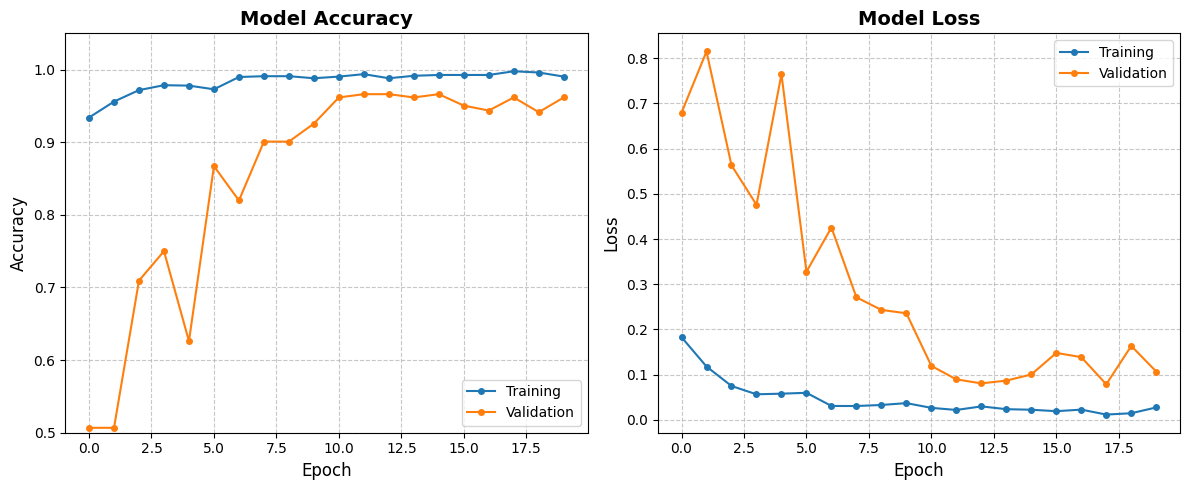

[INFO] Generating confusion matrix...


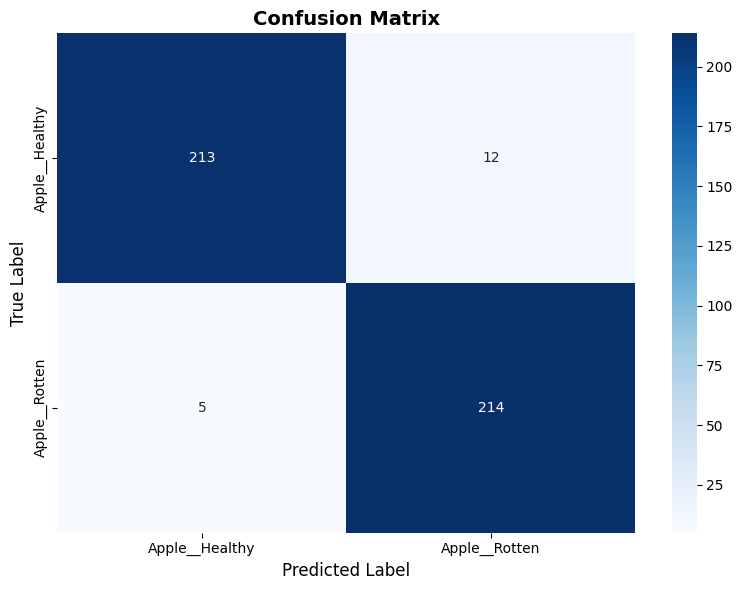

[INFO] Generating model performance metrics...


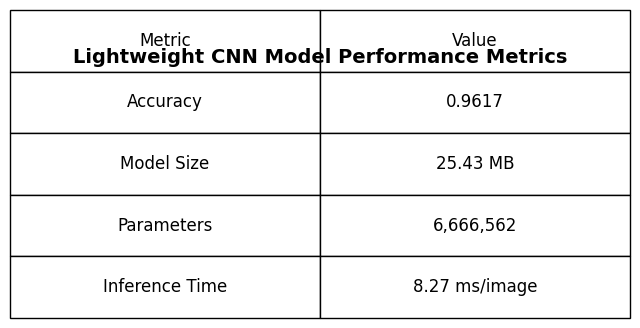

In [10]:
# Evaluate the model and generate visualizations (this cell is solely for evaluation)

print("[INFO] Evaluating enhanced CNN model...")
start_time = time.time()
predIdxs = model.predict(testX, batch_size=BS)
end_time = time.time()
inference_time = (end_time - start_time) / len(testX) * 1000  # ms per image

predIdxs_classes = predIdxs.argmax(axis=1)
trueIdxs = testY.argmax(axis=1)

print(classification_report(trueIdxs, predIdxs_classes, target_names=le.classes_))
test_loss, test_accuracy = model.evaluate(testX, testY, batch_size=BS, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize Training History
print("[INFO] Generating training history plot...")
plot_training_history(H)

# Visualize Confusion Matrix
print("[INFO] Generating confusion matrix...")
cm_accuracy = plot_confusion_matrix(trueIdxs, predIdxs_classes, le.classes_)

# Visualize Model Performance Metrics
print("[INFO] Generating model performance metrics...")
metrics_df = create_model_performance_metrics(model, test_accuracy, inference_time)


In [11]:
model.save("apple_classifier_custom_cnn.keras")